<h1 align="center">Logistic Regression</h1>

In this notebook, we will convert criteria sentence to feature vector by Bert-as-Service, train a Logistic Regression model for criteria sentence classification, and evalute the performance in test data.

* training data (30644 sentences), test data (7697 sentences)
* 44 semantic categories

|#|group topics|semantic categories|
|---|---|----
|1|`Health Status`|`Disease` `Symptom` `Sign` `Pregnancy-related Activity` `Neoplasm Status` `Non-Neoplasm Disease Stage` `Allergy Intolerance` `Organ or Tissue Status` `Life Expectancy` `Oral related`
|2|`Treatment or Health Care`|`Pharmaceutical Substance or Drug` `Therapy or Surgery` `Device` `Nursing`
|3|`Diagnostic or Lab Test`|`Diagnostic` `Laboratory Examinations` `Risk Assessment` `Receptor Status`
|4|`Demographic Characteristics`|`Age` `Special Patient Characteristic` `Literacy` `Gender` `Education` `Address` `Ethnicity`
|5|`Ethical Consideration`|`Consent` `Enrollment in other studies` `Researcher Decision` `Capacity` `Ethical Audit` `Compliance with Protocol`
|6|`Lifestyle Choice`|`Addictive Behavior` `Bedtime` `Exercise` `Diet` `Alcohol Consumer` `Sexual related` `Smoking Status` `Blood Donation`
|7|`Data or Patient Source`|`Encounter` `Disabilities` `Healthy` `Data Accessible`
|8|`Other`|`Multiple`

In [28]:
from __future__ import division

import os
import codecs
import time 
import math
import pickle
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

%matplotlib inline 
import matplotlib.pyplot as plt

<h2>Bert-as-service</h2>

***

download bert-as-service

``` 
pip install bert-serving-server  # server
pip install bert-serving-client  # client, independent of `bert-serving-server
```

start bert-as-service in terminal

```
bert-serving-start -model_dir chinese_L-12_H-768_A-12 -num_worker=4
```

run bert-as-service

In [6]:
from bert_serving.client import BertClient
bc = BertClient()

v = bc.encode(["4.年龄小于65岁。", "存在严重的合并症者"])
print(v)
print(len(v[0]))

[[ 0.84583086 -0.46175382  0.40942535 ...  0.21331571  0.11204454
  -0.12961882]
 [ 0.04718163  0.455918    0.2500301  ... -0.12850839 -0.2012489
  -0.03303002]]
768


<h2>Load data from file and convert criteria sentence to feature matrix</h2>

***

In [19]:
from bert_serving.client import BertClient
bc = BertClient()
tags = ["Disease","Symptom","Sign","Pregnancy-related Activity","Neoplasm Status","Non-Neoplasm Disease Stage",
        "Allergy Intolerance","Organ or Tissue Status","Life Expectancy","Oral related",
        "Pharmaceutical Substance or Drug","Therapy or Surgery","Device","Nursing","Diagnostic",
        "Laboratory Examinations","Risk Assessment","Receptor Status","Age","Special Patient Characteristic",
        "Literacy","Gender","Education","Address","Ethnicity","Consent","Enrollment in other studies",
        "Researcher Decision","Capacity","Ethical Audit","Compliance with Protocol","Addictive Behavior",
        "Bedtime","Exercise","Diet","Alcohol Consumer","Sexual related","Smoking Status","Blood Donation",
        "Encounter","Disabilities","Healthy","Data Accessible","Multiple"]

def _get_feature_matrix(infile):
    X, y = [], []
    criteria_sentences = []
    with open(infile, "r", encoding="utf-8") as inf:
        for line in inf:
            l = line.strip().split("\t")
            criteria_category = l[1]
            criteria_sentence = l[2]
            criteria_sentences.append(criteria_sentence)
            y.append(tags.index(criteria_category))
    X = bc.encode(criteria_sentences)
    return np.array(X), np.array(y)

In [20]:
train_data_file = "../data/train_data.txt"
X_train, y_train = _get_feature_matrix(train_data_file)
print('Train set:', X_train.shape,  y_train.shape)

Train set: (30644, 768) (30644,)


In [22]:
test_data_file = "../data/test_data.txt"
X_test, y_test = _get_feature_matrix(test_data_file)
print ('Test set:', X_test.shape,  y_test.shape)

Test set: (7697, 768) (7697,)


<h2>Modeling (Logistic Regression with Scikit-learn)</h2>

***

<h3>Train</h3>

In [23]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<h3>Predict</h3>

In [24]:
ypredict_test = LR.predict(X_test)
ypredict_test

array([43, 43,  0, ..., 36, 36, 21])

<h3>Confusion matrix</h3>

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, ypredict_test, labels=list(range(len(tags)))))

[[1490    1    4 ...    0    0  132]
 [  26   10    2 ...    0    0    9]
 [  47    2   15 ...    0    0   19]
 ...
 [   2    0    0 ...    4    0    6]
 [   2    0    0 ...    0   16    1]
 [ 249    0    2 ...    1    1  910]]


Confusion matrix, without normalization
[[1490    1    4 ...    0    0  132]
 [  26   10    2 ...    0    0    9]
 [  47    2   15 ...    0    0   19]
 ...
 [   2    0    0 ...    4    0    6]
 [   2    0    0 ...    0   16    1]
 [ 249    0    2 ...    1    1  910]]


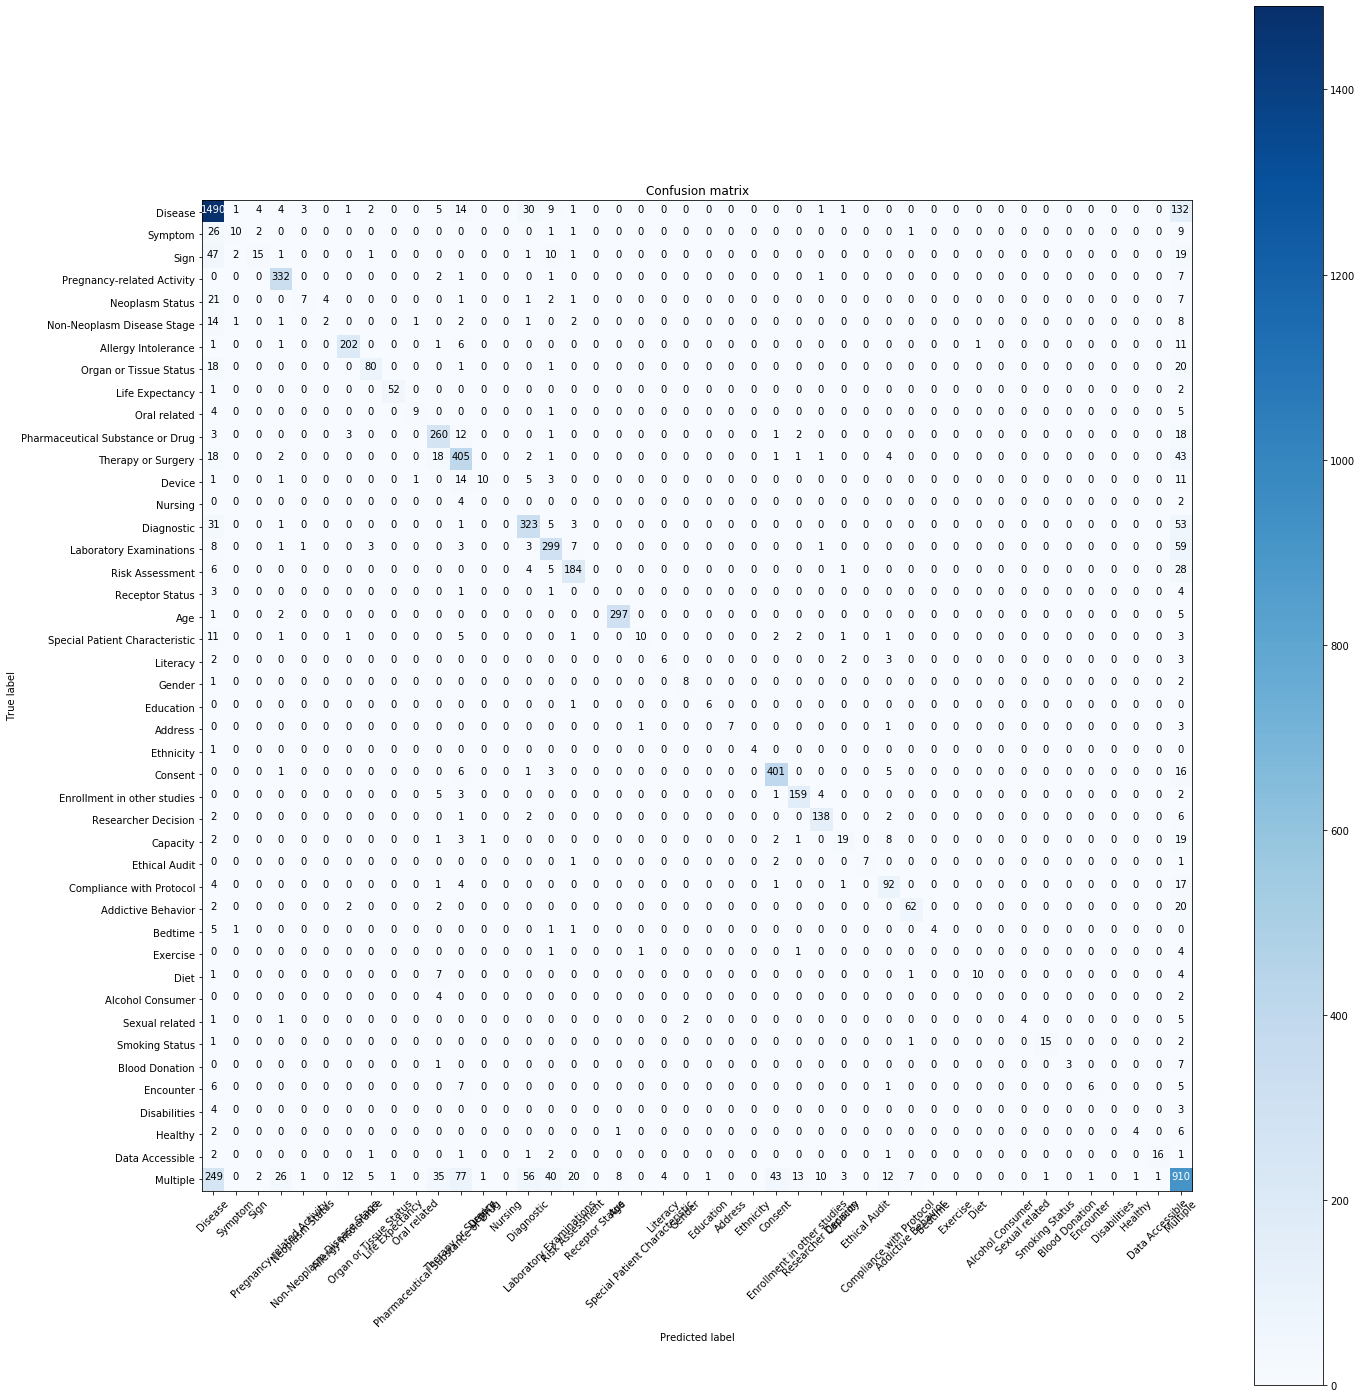

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, ypredict_test, labels=list(range(len(tags))))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=tags,normalize= False,  title='Confusion matrix')

<h2>Save model and test data results</h2>

***

In [34]:
model_save_file = "LR.pickle"
with open(model_save_file, 'wb') as f:
    pickle.dump(LR, f)

In [36]:
test_data_file = "../data/test_data.txt"
test_results_save_file = "test_data_predict.txt"

criteria_ids, criteria_sentences = [], []
with open(test_data_file, "r", encoding="utf-8") as inf:
    for line in inf:
        l = line.strip().split("\t")
        criteria_ids.append(l[0])
        criteria_sentences.append(l[2])

with codecs.open(test_results_save_file, "w", encoding="utf-8") as outf:
    for i in range(len(criteria_ids)):
        outf.write("{}\t{}\t{}\n".format(criteria_ids[i], tags[ypredict_test[i]], criteria_sentences[i]))

<h2>Evaluation</h2>

---

In [41]:
test_data_file = "../data/test_data.txt"
test_results_save_file = "test_data_predict.txt"
test_results_evaluation_save_file = "test_data_evaluation.txt"
os.system("python evaluation.py {} {} > {}".format(test_data_file, test_results_save_file, test_results_evaluation_save_file))

0

In [44]:
with open(test_results_evaluation_save_file, "r") as f:
    for line in f:
        print(line.strip("\n"))

**************************************** Evaluation results*****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.8611           0.7045           0.7750         
                            Address    1.0000           0.5833           0.7368         
                                Age    0.9706           0.9738           0.9722         
                   Alcohol Consumer    0.0000           0.0000           0.0000         
                Allergy Intolerance    0.9140           0.9058           0.9099         
                            Bedtime    1.0000           0.3333           0.5000         
                     Blood Donation    1.0000           0.2727           0.4286         
                           Capacity    0.6786           0.3393           0.4524         
           Compliance with Protocol    0.7077           0.7667           0.7360         
         

<h2>Predict a new input criteria sentence with saved model</h2>

***

In [49]:
# new example
s = ["男女皆有", "年龄大于18岁，", "病人对研究药物过敏。"]

# get feature
from bert_serving.client import BertClient
bc = BertClient()
f = bc.encode(s)

# loads models
loaded_model = pickle.load(open("LR.pickle", "rb"))

# predict
results = loaded_model.predict(f)
predict_tags = [tags[i] for i in results]

print(predict_tags)

['Gender', 'Age', 'Allergy Intolerance']
